In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import datetime
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
import seaborn as sns

# Checking TensorFlow and TensorFlow Hub versions
print("TensorFlow Version:", tf.__version__)
print("TensorFlow Hub Version:", hub.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Mounting Google Drive to the Colab environment (This step is required if your dataset is in Google Drive)
from google.colab import drive
drive.mount('/content/drive')

TensorFlow Version: 2.18.0
TensorFlow Hub Version: 0.16.1
GPU Available: []
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Main directory where your dataset is located
data_dir = pathlib.Path('/content/drive/MyDrive/mini-dataset')  # UPDATE THIS PATH TO THE LOCATION OF YOUR OWN DATASET!

# Image dimensions and batch size
# The optimal size for EfficientNetV2/B0 is 224x224
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 16

print(f"\nLoading dataset from '{data_dir}'...")
raw_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=None,  # Load images one by one
    shuffle=False     # Do not shuffle initially; we will shuffle manually later
)

# Get class names
class_names = raw_ds.class_names
print("Class Names:", class_names)
print("Number of Classes:", len(class_names))

# Get the total number of images
total_images = tf.data.experimental.cardinality(raw_ds).numpy()
print(f"\nTotal Number of Images: {total_images}")

# Shuffle the dataset
raw_ds = raw_ds.shuffle(buffer_size=total_images, seed=42)  # Added seed for deterministic shuffle

# Define dataset split ratios
test_split_ratio = 0.15    # 15% for testing
val_split_ratio = 0.15     # 15% for validation
train_split_ratio = 1.0 - test_split_ratio - val_split_ratio  # The rest for training

# Calculate the number of images per split (rounded to integers)
test_size_images = int(total_images * test_split_ratio)
val_size_images = int(total_images * val_split_ratio)
train_size_images = total_images - test_size_images - val_size_images  # Assign the remaining images to training

# Split the dataset (first test, then split remaining into train/val)
test_ds_raw = raw_ds.take(test_size_images)
remaining_ds_raw = raw_ds.skip(test_size_images)

val_ds_raw = remaining_ds_raw.take(val_size_images)
train_ds_raw = remaining_ds_raw.skip(val_size_images)

# Now batch each dataset
train_ds = train_ds_raw.batch(BATCH_SIZE)
val_ds = val_ds_raw.batch(BATCH_SIZE)
test_ds = test_ds_raw.batch(BATCH_SIZE)

print(f"\nNumber of Training Images: {train_size_images} (approx. %{int(train_split_ratio*100)})")
print(f"Number of Validation Images: {val_size_images} (approx. %{int(val_split_ratio*100)})")
print(f"Number of Test Images: {test_size_images} (approx. %{int(test_split_ratio*100)})")

print(f"Number of Training Batches: {len(train_ds)}")
print(f"Number of Validation Batches: {len(val_ds)}")
print(f"Number of Test Batches: {len(test_ds)}")

# Improve data loading performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)  # Also prefetch the test set


Loading dataset from '/content/drive/MyDrive/mini-dataset'...
Found 1805 files belonging to 5 classes.
Class Names: ['000', '001', '002', '003', '004']
Number of Classes: 5

Total Number of Images: 1805

Number of Training Images: 1265 (approx. %70)
Number of Validation Images: 270 (approx. %15)
Number of Test Images: 270 (approx. %15)
Number of Training Batches: 80
Number of Validation Batches: 17
Number of Test Batches: 17


In [3]:
# This URL loads the feature extractor part of the EfficientNetV2 B0 model
model_url = "https://www.kaggle.com/models/google/efficientnet-v2/TensorFlow2/imagenet1k-b0-feature-vector/2"
print(f"\nEfficientNetV2 model has been created from '{model_url}'")

feature_extractor_layer = hub.KerasLayer(
    model_url,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    trainable=True  # Set to True to allow fine-tuning
)

# Define the input layer
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), name='input_image')

# Lambda layer workaround: Fix for an issue caused by the Hub model
x = tf.keras.layers.Lambda(lambda image: feature_extractor_layer(image))(inputs)

# Dropout layer to reduce overfitting
x = tf.keras.layers.Dropout(0.2)(x)

# Get the number of classes from the dataset
num_classes = len(class_names)

# Output layer: Use softmax activation for classification
outputs = tf.keras.layers.Dense(num_classes, activation='softmax', name='output_class')(x)

# Build the model using Functional API
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Display model architecture summary
model.summary()


EfficientNetV2 model has been created from 'https://www.kaggle.com/models/google/efficientnet-v2/TensorFlow2/imagenet1k-b0-feature-vector/2'


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_class (Dense)            │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,405 (25.02 KB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Training and number of epochs
EPOCHS = 50

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

print(f"\nTraining the model for {EPOCHS} epochs...")
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stopping, tensorboard_callback]
)

print("\nModel training completed!")


Training the model for 50 epochs...
Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 94s 941ms/step - accuracy: 0.3097 - loss: 25.7880 - val_accuracy: 0.6593 - val_loss: 9.8811
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 123s 806ms/step - accuracy: 0.5928 - loss: 11.5478 - val_accuracy: 0.7111 - val_loss: 6.2247
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 82s 805ms/step - accuracy: 0.6368 - loss: 10.2362 - val_accuracy: 0.7222 - val_loss: 5.9856
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 82s 806ms/step - accuracy: 0.6776 - loss: 8.0596 - val_accuracy: 0.7593 - val_loss: 5.2015
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 66s 824ms/step - accuracy: 0.6897 - loss: 6.9809 - val_accuracy: 0.8000 - val_loss: 3.9228
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 64s 803ms/step - accuracy: 0.7125 - loss: 5.6103 - val_accuracy: 0.7519 - val_loss: 5.5861
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 66s 822ms/step - accuracy: 0.7278 - loss: 6.0160 - val_accuracy: 0.7889 - val_loss: 4.2734
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 74s 935ms/step - a

In [5]:
# Saving the model
model_save_path = '/content/drive/MyDrive/my_efficientnetv2_model.keras' # Don't forget to add the .keras or .h5 extension!

print(f"\nSaving the model to '{model_save_path}'")

# Save the trained model to the specified path
model.save(model_save_path)

print("Model successfully saved!")


Saving the model to '/content/drive/MyDrive/my_efficientnetv2_model.keras'
Model successfully saved!



Model Evaluation on the TEST Dataset:
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 705ms/step - accuracy: 0.8174 - loss: 3.0520
Loss: 3.4906
Accuracy: 0.8259


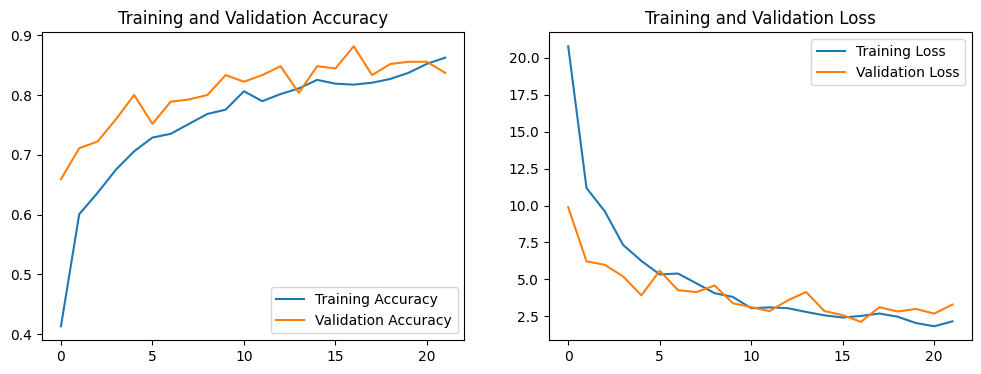

In [6]:
# Model Evaluation and Visualization
print("\nModel Evaluation on the TEST Dataset:")

# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_ds)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Extract training history for accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Define the range for epochs to use on the x-axis
epochs_range = range(len(history.history['accuracy']))

# Plotting training vs. validation accuracy and loss
plt.figure(figsize=(12, 4))

# First subplot: Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')

# Second subplot: Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')

plt.show()

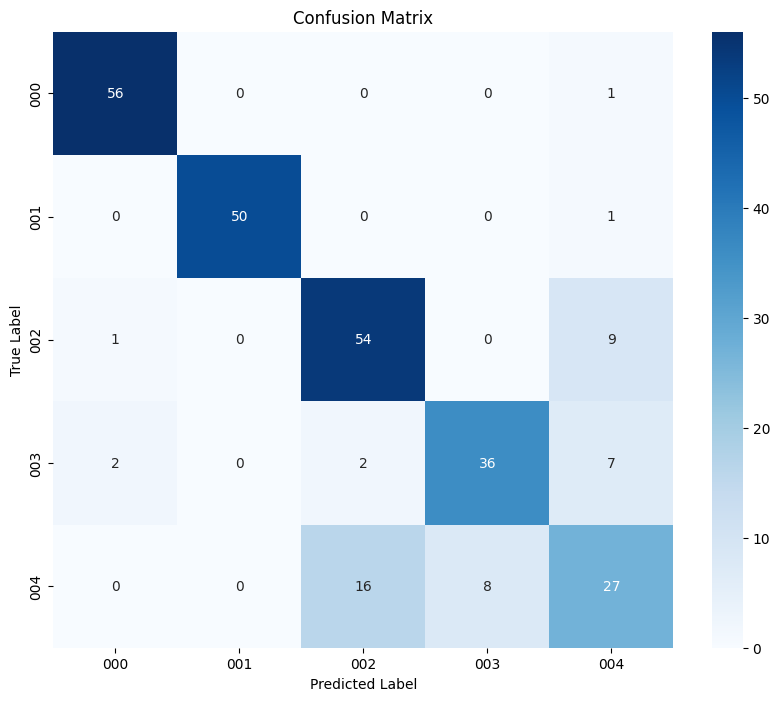

In [7]:
# Confusion Matrix
y_true = []
y_pred = []

# Generate predictions on the test dataset
for images, labels in test_ds:
    predictions = model.predict(images, verbose=0)  # verbose=0 to suppress detailed output
    y_true.extend(labels.numpy())  # True labels
    y_pred.extend(np.argmax(predictions, axis=1))  # Predicted labels (from softmax output)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,  # Show numbers inside the boxes
    xticklabels=class_names,  # Predicted class names on x-axis
    yticklabels=class_names,  # True class names on y-axis
    fmt="d",  # Integer formatting
    cmap="Blues"  # Color map
)

# Add labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [8]:
print("\nClassification Report:\n")

print(classification_report(y_true, y_pred, target_names=class_names))

# Calculate the balanced accuracy score, which accounts for class imbalance
balanced_acc = balanced_accuracy_score(y_true, y_pred)

print(f"\nBalanced Accuracy: {balanced_acc:.4f}")


Classification Report:

              precision    recall  f1-score   support

         000       0.95      0.98      0.97        57
         001       1.00      0.98      0.99        51
         002       0.75      0.84      0.79        64
         003       0.82      0.77      0.79        47
         004       0.60      0.53      0.56        51

    accuracy                           0.83       270
   macro avg       0.82      0.82      0.82       270
weighted avg       0.82      0.83      0.82       270


Balanced Accuracy: 0.8204
